El presente ejemplo sigue la tarea de

https://colab.research.google.com/drive/1s2rYaM1iVeYQmhdcbej_B1m9ONtrGUmF?authuser=3

Pero implementada usando la potencia de Google Earth Engine y la computación en la nube.

In [1]:
!pip list | grep rasterio

rasterio                          1.4.3


In [2]:
!pip install rasterio
#!pip install earthengine-api --upgrade

In [3]:
!pip list | grep earth

CONSIGNAS:

* Recortar las imágenes a la zona comprendida entre las coordenadas
    24.867°N, 64.539°W, 25.290°S, 63.829°E

* Calcular el NDVI para cada imagen por año y apilarlas

* Clasificar el apilado de NDVI utilizando el método de k-means con 3 clases espectrales

* Reclasificar la escena según:

        * zonas con alto NDVI que no cambiaron (color  RGB: 45, 207, 96)

        * zonas con bajo NDVI que no cambiaron (color  RGB: 255, 255, 191)

        * zonas con disminución de NDVI (color  RGB: 252, 141, 89)

* Imprimir la imagen clasificada obtenida

In [4]:
# IMPORTACIONES
import ee
import geemap
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib import colors

ModuleNotFoundError: No module named 'ee'

In [ ]:
# Autorizar GEE
ee.Authenticate()
ee.Initialize(project='ee-train-romoanahi') # reemplazar x el nombre de tu proyecto

Recortar las imágenes a la zona comprendida entre las coordenadas

    24.867°N, 64.539°W, 25.290°S, 63.829°E

In [ ]:
# Area

area =  ee.Geometry.Polygon(
        [[[-64.539, -24.867],
          [-64.539, -25.290],
          [-63.829, -25.290],
          [-63.829, -24.867]]]);

Solicitamos las imágenes a GEE para 1986

In [ ]:
# Para Landsat 5
L5 = (ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
     .filter(ee.Filter.eq('WRS_PATH', 230))
     .filter(ee.Filter.eq('WRS_ROW', 77))
     .filterDate('1986-01-06', '1986-01-08')
     .first()
     .clip(area))

Visualizamos la imagen

In [ ]:
Map = geemap.Map()
Map.add_basemap('SATELLITE')
Map.centerObject(area, 12)
Map.addLayer(L5,{}, "1986")
Map.addLayer(L5.geometry(), {'color': 'white'}, "Salta")


Map

Map(center=[-25.078800411752148, -64.18399999999993], controls=(WidgetControl(options=['position', 'transparen…

Ver el sgte link para NDVI

https://eos.com/es/blog/indice-de-vegetacion-de-diferencia-normalizada-o-ndvi/

Calculamos una nueva banda NDVI

In [ ]:
# NDVI L5
ndvi_l5 =  L5.normalizedDifference(['SR_B4', 'SR_B3']).rename('NDVI')

Agregamos y visualizamos la banda

In [ ]:
Map.addLayer(ndvi_l5.clip(area), {'min': 0, 'max': 1, 'palette':['red','yellow','green']}, 'NDVI')
Map

Map(bottom=75286.0, center=[-25.111707696829782, -63.896624319118665], controls=(WidgetControl(options=['posit…

Idem para 2017

In [ ]:
# Para Landsat 8
L8 = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
     .filter(ee.Filter.eq('WRS_PATH', 230))
     .filter(ee.Filter.eq('WRS_ROW', 77))
     .filterDate('2017-12-29', '2017-12-31')
     .first()
     .clip(area))

In [ ]:
# NDVI L8
ndvi_l8 =  L8.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

Agregamos banda 2017 al mapa

In [ ]:
Map.addLayer(ndvi_l8.clip(area), {'min': 0, 'max': 1, 'palette':['red','yellow','green']}, '2017')
Map

Map(bottom=75286.0, center=[-25.111707696829782, -63.896624319118665], controls=(WidgetControl(options=['posit…

Exportar a Drive solamente las bandas de NDVI

In [ ]:
# Exportando

task = ee.batch.Export.image.toDrive(
      image = ndvi_l5,
      description = 'NDVI_l5',
      folder = 'PYTHON_EXPORT',
      scale= 30,
      region = area,
      crs = 'EPSG:4326'
    )
# Inicie una tarea de exportación:
task.start()
# Verifique el estado de la tarea de exportación:
task.status()

{'state': 'READY',
 'description': 'NDVI_l5',
 'priority': 100,
 'creation_timestamp_ms': 1754695002650,
 'update_timestamp_ms': 1754695002650,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'QOK2EB3FSMUKJHNNZK3CHU7Q',
 'name': 'projects/ee-train-romoanahi/operations/QOK2EB3FSMUKJHNNZK3CHU7Q'}

In [ ]:
task = ee.batch.Export.image.toDrive(
      image = ndvi_l8,
      description = 'NDVI_l8',
      folder = 'PYTHON_EXPORT',
      scale= 30,
      region = area,
      crs = 'EPSG:4326'
    )
# Inicie una tarea de exportación:
task.start()
# Verifique el estado de la tarea de exportación:
task.status()

{'state': 'READY',
 'description': 'NDVI_l8',
 'priority': 100,
 'creation_timestamp_ms': 1754695029938,
 'update_timestamp_ms': 1754695029938,
 'start_timestamp_ms': 0,
 'task_type': 'EXPORT_IMAGE',
 'id': 'J3FLJUCBQM3TNC2PUTJA2WOG',
 'name': 'projects/ee-train-romoanahi/operations/J3FLJUCBQM3TNC2PUTJA2WOG'}

# Batch export timer:
Para evitar que la tarea falle por exceso de flujo de datos, se puede usar un temporizador


In [ ]:
import time

# Crear la tarea de exportación
task = ee.batch.Export.image.toDrive(
    image=ndvi_l8,
    description='NDVI_l8',
    folder='PYTHON_EXPORT',
    scale=30,
    region=area,
    crs='EPSG:4326'
)

# Iniciar la tarea
task.start()
print("Export task started...")

# Monitorear la tarea cada 30 segundos
while task.active():
    print("Task is still running... Waiting 30 seconds.")
    time.sleep(30)
    print("Status:", task.status())

# Resultado final
status = task.status()
if status['state'] == 'COMPLETED':
    print("Export completed successfully.")
else:
    print("Export failed with error:", status.get('error_message'))

EXPORTACIÓN A DRIVE

In [ ]:
# MONTAR DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Abrir y ver la imagen obtenida

In [ ]:
# ndvi_l5 - Drive
ndvi_l5_D = rasterio.open("/content/drive/MyDrive/PYTHON_EXPORT/NDVI_l5.tif")
print(ndvi_l5_D.dtypes[0])
ndvi_l5_D


float32


<open DatasetReader name='/content/drive/MyDrive/PYTHON_EXPORT/NDVI_l5.tif' mode='r'>

In [ ]:
ndvi_1986 = ndvi_l5_D.read(1).astype('float64')
print(ndvi_1986.shape)
ndvi_1986

(1572, 2635)


array([[0.43545747, 0.47489727, 0.46476251, ..., 0.24973859, 0.24973859,
        0.25401315],
       [0.45289543, 0.48267555, 0.49263915, ..., 0.25401315, 0.25823927,
        0.25823927],
       [0.46661574, 0.45693818, 0.44504201, ..., 0.25818723, 0.25401315,
        0.25823927],
       ...,
       [       nan,        nan,        nan, ..., 0.28563923, 0.28563923,
        0.28166151],
       [       nan,        nan,        nan, ..., 0.28561035, 0.28561035,
        0.28166151],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [ ]:
# ndvi_l8 - Drive
ndvi_l8_D = rasterio.open("/content/drive/MyDrive/PYTHON_EXPORT/NDVI_l8.tif")
print(ndvi_l8_D.dtypes[0])
ndvi_l8_D


float32


<open DatasetReader name='/content/drive/MyDrive/PYTHON_EXPORT/NDVI_l8.tif' mode='r'>

In [ ]:
ndvi_2017 = ndvi_l8_D.read(1).astype('float64')
print(ndvi_2017.shape)
ndvi_2017

(1572, 2635)


array([[0.3307071 , 0.34849477, 0.3662101 , ..., 0.11083314, 0.11105224,
        0.10962708],
       [0.3421002 , 0.35324141, 0.37051162, ..., 0.11158898, 0.10993826,
        0.11001751],
       [0.35655096, 0.3623639 , 0.39010626, ..., 0.10987873, 0.110007  ,
        0.11060456],
       ...,
       [0.34576768, 0.37165943, 0.36752582, ..., 0.28903928, 0.28903928,
        0.28828606],
       [0.39608634, 0.38068748, 0.37803844, ..., 0.29406929, 0.29406929,
        0.28462017],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

Imputar los NaN como pixeles no significativos

In [ ]:
# Valores NAN - L5
ndvi_1986[np.isnan(ndvi_1986)] = 0.
ndvi_1986

array([[0.43545747, 0.47489727, 0.46476251, ..., 0.24973859, 0.24973859,
        0.25401315],
       [0.45289543, 0.48267555, 0.49263915, ..., 0.25401315, 0.25823927,
        0.25823927],
       [0.46661574, 0.45693818, 0.44504201, ..., 0.25818723, 0.25401315,
        0.25823927],
       ...,
       [0.        , 0.        , 0.        , ..., 0.28563923, 0.28563923,
        0.28166151],
       [0.        , 0.        , 0.        , ..., 0.28561035, 0.28561035,
        0.28166151],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
ndvi_1986.min()

np.float64(-0.10360315442085266)

In [ ]:
ndvi_1986.max()

np.float64(0.542332649230957)

In [ ]:
ndvi_2017[np.isnan(ndvi_2017)] = 0.
ndvi_2017

array([[0.3307071 , 0.34849477, 0.3662101 , ..., 0.11083314, 0.11105224,
        0.10962708],
       [0.3421002 , 0.35324141, 0.37051162, ..., 0.11158898, 0.10993826,
        0.11001751],
       [0.35655096, 0.3623639 , 0.39010626, ..., 0.10987873, 0.110007  ,
        0.11060456],
       ...,
       [0.34576768, 0.37165943, 0.36752582, ..., 0.28903928, 0.28903928,
        0.28828606],
       [0.39608634, 0.38068748, 0.37803844, ..., 0.29406929, 0.29406929,
        0.28462017],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
ndvi_2017.min()

np.float64(-0.16418206691741943)

In [ ]:
ndvi_2017.max()

np.float64(0.5564881563186646)

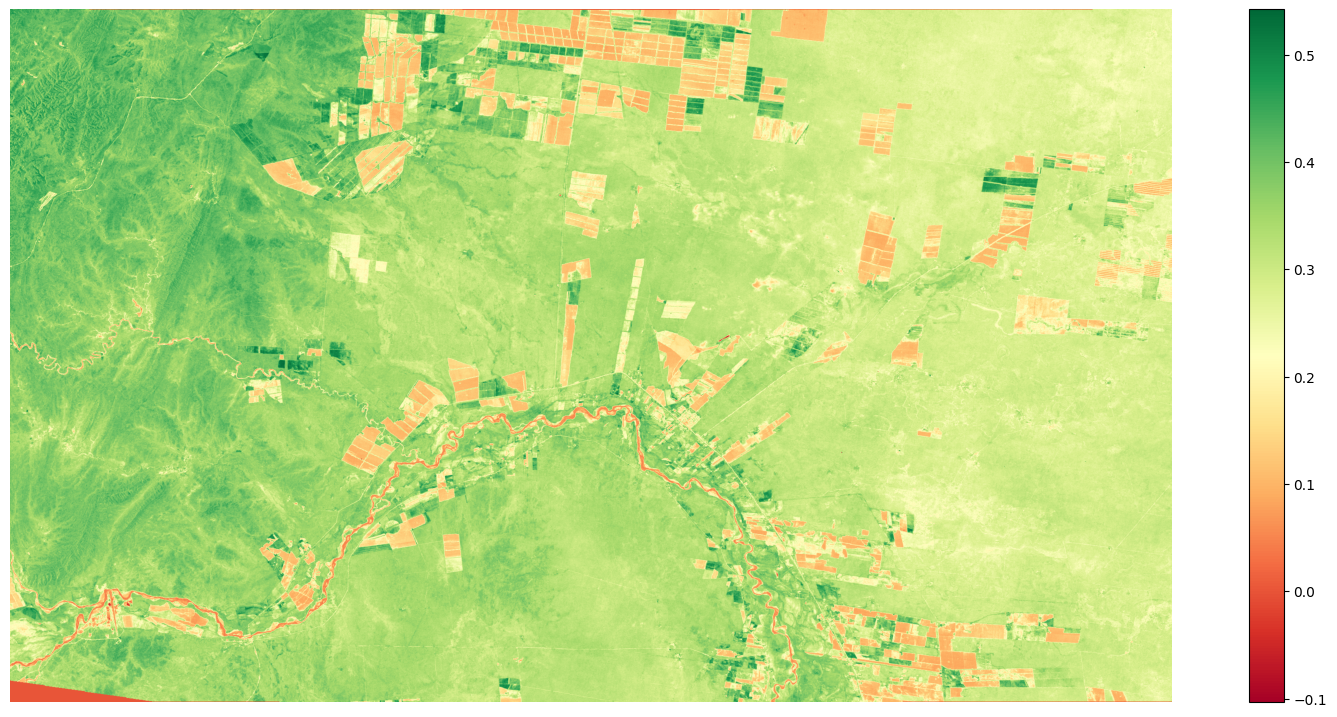

In [ ]:
# Graficos l5 - l8
fig, ax = plt.subplots(figsize=(20, 9))
plt.imshow(ndvi_1986, 'RdYlGn')
# Barra de Color
plt.colorbar()
plt.axis('off')
plt.show()

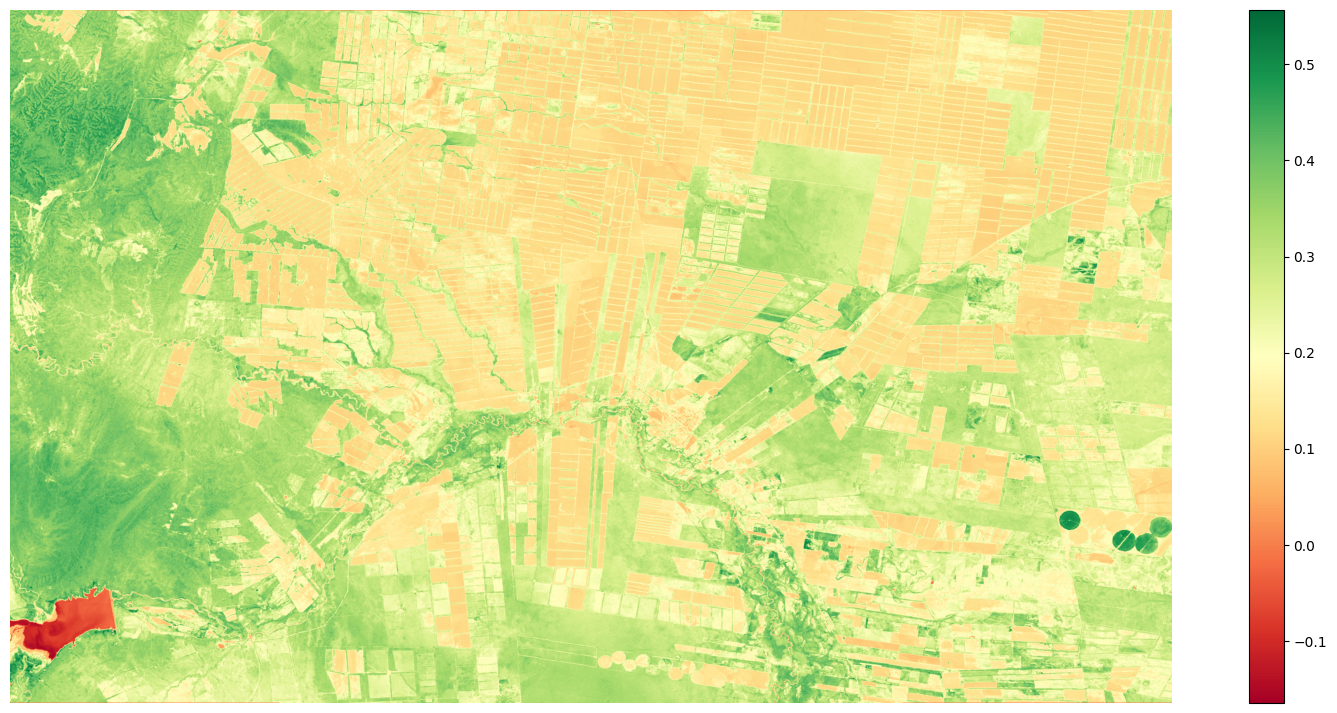

In [ ]:
fig, ax = plt.subplots(figsize=(20, 9))
plt.imshow(ndvi_2017, 'RdYlGn')
# Barra de Color
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
# Convirtiendo las matrices de pixeles a un vector de una sola fila
ndvi_1986_f = ndvi_1986.flatten()
ndvi_2017_f = ndvi_2017.flatten()

In [ ]:
# Convirtiendo a Data Frame
df_NDVI = pd.DataFrame({'NDVI_1986': ndvi_1986_f,'NDVI_2017': ndvi_2017_f})
df_NDVI

NDVI_1986  NDVI_2017
0         0.435457   0.330707
1         0.474897   0.348495
2         0.464763   0.366210
3         0.468027   0.397386
4         0.473701   0.413861
...            ...        ...
4142215   0.000000   0.000000
4142216   0.000000   0.000000
4142217   0.000000   0.000000
4142218   0.000000   0.000000
4142219   0.000000   0.000000

[4142220 rows x 2 columns]

In [ ]:
#KMEANS
kmeans = KMeans(n_clusters = 3, random_state = 16)
#entreno
kmeans.fit(df_NDVI) #ajusta el modelo
#usar el modelo entrenado para poner etiquetas
etiquetas = kmeans.predict(df_NDVI)

In [ ]:
df_NDVI['defo'] = etiquetas
df_NDVI

NDVI_1986  NDVI_2017  defo
0         0.435457   0.330707     0
1         0.474897   0.348495     0
2         0.464763   0.366210     0
3         0.468027   0.397386     0
4         0.473701   0.413861     0
...            ...        ...   ...
4142215   0.000000   0.000000     1
4142216   0.000000   0.000000     1
4142217   0.000000   0.000000     1
4142218   0.000000   0.000000     1
4142219   0.000000   0.000000     1

[4142220 rows x 3 columns]

In [ ]:
df_NDVI['defo'].unique()

array([0, 2, 1], dtype=int32)

In [ ]:
df_NDVI['defo'].value_counts()

defo
1    1723070
2    1389484
0    1029666
Name: count, dtype: int64

In [ ]:
centroides=pd.DataFrame(kmeans.cluster_centers_, columns=['NDVI_1986','NDVI_2017'])
centroides

NDVI_1986  NDVI_2017
0   0.377200   0.352659
1   0.287172   0.133040
2   0.296048   0.269195

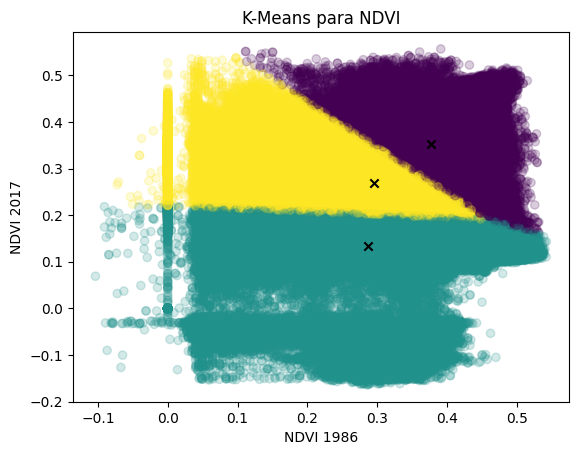

In [ ]:
plt.scatter(df_NDVI['NDVI_1986'], df_NDVI['NDVI_2017'], c = df_NDVI['defo'], alpha=0.2)
plt.scatter(centroides['NDVI_1986'], centroides['NDVI_2017'], c = 'black', marker = 'x')
plt.title('K-Means para NDVI')
plt.xlabel('NDVI 1986')
plt.ylabel('NDVI 2017')
plt.show()

In [ ]:
defo=etiquetas.reshape(ndvi_1986.shape)
defo

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [ ]:
ndvi_1986.shape

(1572, 2635)

In [ ]:
ndvi_2017.shape

(1572, 2635)

In [ ]:
defo.shape

(1572, 2635)

In [ ]:
type(defo)

numpy.ndarray

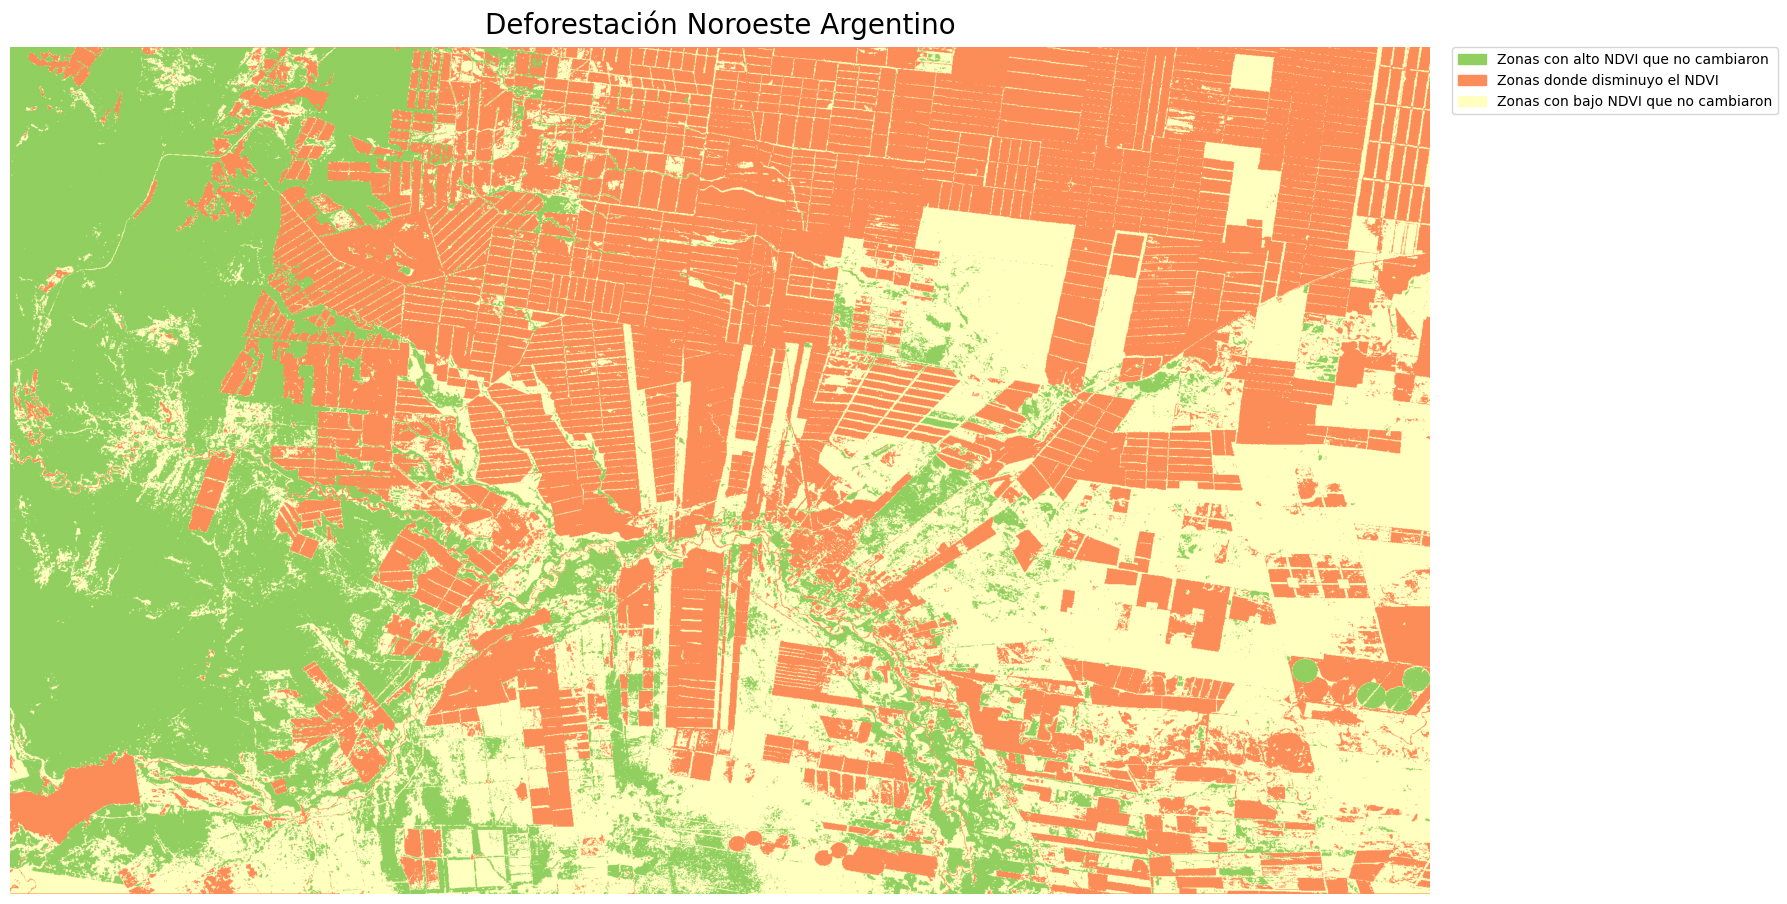

In [ ]:
# Grafico NDVI Kmean
fig, ax = plt.subplots(figsize=(22, 11))
# Paleta de colores
cmap = colors.ListedColormap(["#91cf60","#fc8d59", "#ffffbf"])
# Nombres de la leyenda
texts = ['Zonas con alto NDVI que no cambiaron','Zonas donde disminuyo el NDVI', 'Zonas con bajo NDVI que no cambiaron']
patches = [mpatches.Patch(color = cmap(i), label="{:s}".format(texts[i]) ) for i in range(len(texts))]
# limites de cada color
limites = [0, 1, 2, 3]
norm = colors.BoundaryNorm(limites, cmap.N)
#Imprimiendo el mapa
plt.imshow(defo, cmap = cmap, norm=norm)
# Titulo
plt.title('Deforestación Noroeste Argentino', {'size' : 20 }, pad = 10)
# Leyenda
plt.legend(handles=patches, bbox_to_anchor=(1.25, 0.96), loc='right', ncol=1 )
plt.axis('off')
plt.show()


Definición  | Color R,G,B | Color Hexa
-------------------|------------------|------------------
Zonas con alto NDVI que no cambiaron       | 145,207,96| "#91cf60"
Zonas con bajo NDVI que no cambiaron       | 255,255,191| "#ffffbf"
Zonas donde disminuyo el NDVI      | 252,141,89| "#fc8d59"